In [179]:
%pylab inline
%load_ext autoreload
%autoreload 2

from collections import Counter, defaultdict
import pandas as pd
import glob
import os
import itertools
from matplotlib.legend import Legend
from matplotlib.lines import Line2D
from gcca import GCCA
import logging
import seaborn as sns
sns.set_context('poster')#, font_scale=2)
sns.set_style('white')
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
from ee546_utils import *
from scipy.stats import hypergeom
#MARKERS = list(Line2D.filled_markers)
MARKERS = ['o',  'x', '^', '*','>', '<', 's',  'H',  '8', 'p', 'h',  'D', 'd', 'P']
TISSUES_SHORT_FORM_MAP = {'lv': 'liver',
                          'skm': 'muscle',
                          'br': 'brain',
                          'ht': 'heart',
                          'kd': 'kidney',
                          'cb': 'cerebellum',
                          'lv': 'liver',
                          'ts': 'testes'
                         }

SPECIES_COMMON_NAME_MAP = {"bos_taurus": "Cow",
                           "rattus_norvegicus": "Rat",
                           "pongo_abelii": "Orangutan",
                           "monodelphis_domestica": "Opossum",
                           "macaca_mulatta": "Rhesus",
                           "pan_troglodytes": "Chimp",
                           "mus_musculus": "Mouse",
                           "homo_sapiens": "Human",
                           "gallus_gallus": "Chicken",
                           "ornithorhynchus_anatinus":  "Platypus",
                           "gorilla_gorilla": "Gorilla",
                           "pan_paniscus": "Bonobo"}

SPECIES_COMMON_NAME_MAP_SHORT = {"btaurus": "Cow",
                                 "rnorvegicus": "Rat",
                                 "pabelii": "Orangutan",
                                 "mdomestica": "Opposum",
                                 "mmulatta": "Rhesus",
                                 "ptroglodytes": "Chimp",
                                 "mmusculus": "Mouse",
                                 "hsapiens": "Human",
                                 "ggallus": "Chicken",
                                 "oanatinus":  "Platypus",
                                 "ggorilla": "Gorrila",
                                 "ppaniscus": "Bonobo"}
SRP007412_cols_to_use = [#'cb_M_1', 'lv_F_1', 'ts_M_1', 'target_id', 
                         'kd_F_1', 'ht_M_1',
                         'ht_F_1', 'cb_F_1', 'br_M_1',
                         'br_F_1', 'kd_M_1', 'lv_M_1']

MARKERS = ['o',  'x', '^', '*', 'H', '<', 's',  '>', '8', 'p', 'h',  'D', 'd', 'P']
def species_short(name):
    return name[0] + name.split('_')[1]


def _get_PCA_colors_markers(target_names):
    colors = {}
    indexes = defaultdict(list)
    all_species = {}
    row_colors = []
    for index, target_name in enumerate(target_names):
        species = target_name.split('_')[0]
        tissue = target_name.split('_')[1]
        if tissue not in colors.keys():
            colors[tissue] = sns.color_palette('tab10')[len(colors)]
        row_colors.append(colors[tissue])
        indexes[tissue].append(index)
        all_species[index] = species
        
    colors_dict = {}
    colors_list = []
    indexes_x = defaultdict(list)
    indexes_y = defaultdict(list)
    markers_dict = {}
    markers_list = []
    for index, target_name in enumerate(target_names):
        species = target_name.split('_')[0]
        tissue = target_name.split('_')[1]
        if tissue not in colors_dict.keys():
            colors_dict[tissue] = sns.color_palette('tab10')[len(colors_dict)]
        if species not in markers_dict.keys():
            markers_dict[species] = MARKERS[len(markers_dict)]
        markers_list.append(markers_dict[species])
        colors_list.append(colors_dict[tissue])
        indexes[tissue].append(index)
    return indexes, markers_list, colors_list, colors_dict, markers_dict

def do_PCA(X, target_names, ax=None):
    sns.set_context('poster')#, font_scale=1.75)
    sns.set_style('white')
    pca = PCA(n_components=min(X.shape))
    X_r = pca.fit(X).transform(X)
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 12))
    else:
        fig = ax.get_figure()
    colors = sns.color_palette('Paired')
    lw = 2
    indexes, markers_list, colors_list, colors_dict, markers_dict = _get_PCA_colors_markers(target_names)


    for tissue, values in indexes.items():
        for value in values:
            ax.scatter(X_r[value, 0], 
                       X_r[value, 1], 
                       alpha=0.4,
                       color=colors_dict[tissue], 
                       marker=markers_list[value],
                       lw=5)
        
    scatter_points = []
    annotations = []
    for tissue, color in colors_dict.items():
        p = ax.scatter([], [], color=color, label=tissue)
        if tissue in TISSUES_SHORT_FORM_MAP.keys():
            tissue = TISSUES_SHORT_FORM_MAP[tissue]
        annotations.append(tissue)
        scatter_points.append(p)
        
   
    leg = Legend(ax, scatter_points, annotations, title='Tissue',
                 bbox_to_anchor=(0., 1.02, 1., .02), loc=0,
                 fancybox=True, shadow=True,borderaxespad=0,
                 ncol=5, mode="expand")
    ax.add_artist(leg)

    scatter_points = []
    annotations = []
    for species, marker in markers_dict.items():
        p = ax.scatter([], [], marker=marker, color='black', label=species)
        annotations.append(SPECIES_COMMON_NAME_MAP_SHORT[species])
        scatter_points.append(p)
        
    #leg = Legend(ax, scatter_points, annotations, title='Species',
    #             bbox_to_anchor=(1, 1), loc='upper right',borderaxespad=0)
    leg = Legend(ax, scatter_points, annotations, title='Species', ncol=3, 
             bbox_to_anchor=(0.5, -0.4), loc='lower center',)

    ax.add_artist(leg)
    
    #ax.set_title('PCA')
    ax.set_xlabel('PC1 ({:.2f} %)'.format(pca.explained_variance_ratio_[0]*100))
    ax.set_ylabel('PC2 ({:.2f} %)'.format(pca.explained_variance_ratio_[1]*100))
    #fig.tight_layout()
    
    return X_r, fig

def _get_CCA_colors_markers(target_names):
    colors_dict = {}
    colors_list = []
    indexes_x = defaultdict(list)
    indexes_y = defaultdict(list)
    markers_dict = {}
    markers_list = []
    for index, target_name in enumerate(target_names):
        species = target_name.split('_')[0]
        tissue = target_name.split('_')[1]
        if tissue not in colors_dict.keys():
            colors_dict[tissue] = sns.color_palette('tab10')[len(colors_dict)]
        if species not in markers_dict.keys():
            markers_dict[species] = MARKERS[len(markers_dict)]
        markers_list.append(markers_dict[species])
        colors_list.append(colors_dict[tissue])
        if index < X.shape[0]:
            indexes_x[tissue].append(index)
        else:
            indexes_y[tissue].append(index-X.shape[0])
    return indexes_x, indexes_y, markers_list, colors_list, colors_dict, markers_dict
    
def do_CCA(X, Y, target_names, ax=None):
    
    sns.set_context('poster')#, font_scale=1.7)
    sns.set_style('white')
    cca = CCA(n_components=2)
    cca.fit(X, Y)
    X_c, Y_c = cca.transform(X, Y)
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 12))
    else:
        fig = ax.get_figure()    #assert 
    indexes_x, indexes_y, markers_list, colors_list, colors_dict, markers_dict = _get_CCA_colors_markers(target_names)
    for tissue, values in indexes_x.items():
        for value in values:
            ax.scatter(X_c[value, 0], 
                       X_c[value, 1], 
                       alpha=0.4,
                       color=colors_dict[tissue], 
                       marker=markers_list[value],
                       lw=5)
    for tissue, values in indexes_y.items():
        for value in values:
            ax.scatter(Y_c[value, 0], 
                       Y_c[value, 1], 
                       alpha=0.4,
                       color=colors_dict[tissue], 
                       marker=markers_list[value+X_c.shape[0]],
                       lw=5)
    scatter_points = []
    annotations = []
    for tissue, color in colors_dict.items():
        p = ax.scatter([], [], color=color, label=tissue)
        if tissue in TISSUES_SHORT_FORM_MAP.keys():
            tissue = TISSUES_SHORT_FORM_MAP[tissue]
        annotations.append(tissue)
        scatter_points.append(p)
        
    leg = Legend(ax, scatter_points, annotations, title='Tissue',
                 bbox_to_anchor=(0., 1.02, 1., .02), loc=0,
                 fancybox=True, shadow=True,borderaxespad=0,
                 ncol=3, mode="expand")
    ax.add_artist(leg)

    scatter_points = []
    annotations = []
    for species, marker in markers_dict.items():
        p = ax.scatter([], [], marker=marker, color='black', label=species)
        annotations.append(SPECIES_COMMON_NAME_MAP_SHORT[species])
        scatter_points.append(p)
        
    leg = Legend(ax, scatter_points, annotations, title='Species', ncol=3, 
             bbox_to_anchor=(0.5, -0.35), loc='lower center',)
    ax.add_artist(leg)
    ax.set_xlabel('CC1')
    ax.set_ylabel('CC2')
    return fig

def normalize_df_rowwise(df):
    df_centered = df.sub(df.mean(axis=1), axis=0)
    df_centered = df_centered.div(df_centered.std(axis=1), axis=0)
    return df_centered

def normalize_df_colwise(df):
    df_centered = df.sub(df.mean(axis=0), axis=1)
    df_centered = df_centered.div(df_centered.std(axis=0), axis=1)
    return df_centered

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 01. Read Data

In [136]:
ortho_pairwise = {}
for f in glob.glob('../ortholog_tsv/*.tsv'):
    if 'ortholog_one2one' in f:
        continue
    second_species = f.split('/')[-1].replace('.tsv', '').split('_')[-1]
    print(f)
    ortho_pairwise[f.split('/')[-1].replace('.tsv', '')] = pd.read_table(f)[['ensembl_gene_id', '{}_homolog_ensembl_gene'.format(second_species), '{}_homolog_orthology_type'.format(second_species)]].set_index('ensembl_gene_id')

../ortholog_tsv/mmusculus_btaurus.tsv
../ortholog_tsv/mmusculus_ggallus.tsv
../ortholog_tsv/mmusculus_ggorilla.tsv
../ortholog_tsv/mmusculus_hsapiens.tsv
../ortholog_tsv/mmusculus_mdomestica.tsv
../ortholog_tsv/mmusculus_mmulatta.tsv
../ortholog_tsv/mmusculus_oanatinus.tsv
../ortholog_tsv/mmusculus_pabelii.tsv
../ortholog_tsv/mmusculus_ppaniscus.tsv
../ortholog_tsv/mmusculus_ptroglodytes.tsv
../ortholog_tsv/mmusculus_rnorvegicus.tsv


In [137]:
ONE2ONE_orthologs = pd.read_table('../ortholog_tsv/ortholog_one2one.tsv')

# 02. Read kallisto tables SRP007412

In [138]:
kallisto_counts = {}
srp_species =  defaultdict(list)
for f in glob.glob('../cross-species-data/SRP007412-*_kallisto_gene_tables.tsv'):
    sample_name = f.split('/')[-1].replace('_kallisto_gene_tables.tsv', '')
    srp, species = sample_name.split('-')
    species = species[0] + species.split('_')[-1]
    kallisto_counts['{}_{}'.format(srp, species)] = pd.read_table(f)
    srp_species[srp].append(species)

In [139]:
srp = 'SRP007412'
pairwise_kallisto_counts = {}
pairwise_kallisto_counts_normalized = {}
pairwise_kallisto_counts_normalized_individual = defaultdict(dict)
for species1, species2 in itertools.combinations(srp_species[srp], 2):
    # load counts
    counts1 = kallisto_counts['{}_{}'.format(srp, species1)]
    counts2 = kallisto_counts['{}_{}'.format(srp, species2)]
    
    if species1 ==  'mmusculus':
        species1, species2 = species2, species1
        counts1, counts2 = counts2, counts1
        #cols_to_use = counts1.columns.tolist()
        # Only use these columns in the second dataframe
        #counts2 = counts2.loc[:, cols_to_use]
    if species2 ==  'mmusculus':
        cols_to_use = counts2.columns.tolist()
        # Only use these columns in the second dataframe
        counts1 = counts1.loc[:, cols_to_use]
    intersecting_columns = set(counts1.columns.tolist()).intersection(set(counts2.columns.tolist()))
    intersecting_columns = list(sorted(intersecting_columns))
    
    counts1 = counts1.loc[:, intersecting_columns]
    counts2 = counts2.loc[:, intersecting_columns]
                                                                    
    if species2 != 'mmusculus':
        ortho1 = ortho_pairwise['mmusculus_{}'.format(species1)]
        ortho1 = ortho1.loc[ortho1['{}_homolog_orthology_type'.format(species1)]=='ortholog_one2one']
        ortho1 = ortho1.drop(columns=['{}_homolog_orthology_type'.format(species1)]) 
    
        ortho2 = ortho_pairwise['mmusculus_{}'.format(species2)]
        ortho2 = ortho2.loc[ortho2['{}_homolog_orthology_type'.format(species2)]=='ortholog_one2one']
        ortho2 = ortho2.drop(columns=['{}_homolog_orthology_type'.format(species2)]) 
        
        ortho_12 = ortho1.join(ortho2, how='outer').dropna().reset_index(drop=True)\
                    .set_index('{}_homolog_ensembl_gene'.format(species1))
        species2_lookup_col = '{}_homolog_ensembl_gene'.format(species2)
        species1_ortho_genes  = ortho_12.index
        species2_ortho_genes  = ortho_12['{}_homolog_ensembl_gene'.format(species2)]
        
        
        counts1_trimmed = counts1.loc[species1_ortho_genes].dropna()
        counts2_trimmed = counts2.loc[species2_ortho_genes].dropna()
    
        new_index_genes = counts1_trimmed.index
        reduced_set = ortho_12.loc[new_index_genes]
        reduced_set = reduced_set.loc[reduced_set[species2_lookup_col].isin(counts2_trimmed.index)]
        counts1_trimmed = counts1_trimmed.loc[reduced_set.index]
        counts2_trimmed = counts2_trimmed.loc[reduced_set[species2_lookup_col]]
        del ortho_12
        del reduced_set
        del ortho1
        del ortho2
    else:
        
        ortho = ortho_pairwise['mmusculus_{}'.format(species1)]
        ortho = ortho.loc[ortho['{}_homolog_orthology_type'.format(species1)]=='ortholog_one2one']
        ortho = ortho.drop(columns=['{}_homolog_orthology_type'.format(species1)]) 
        species2_lookup_col = '{}_homolog_ensembl_gene'.format(species1)

        species1_ortho_genes  = ortho['{}_homolog_ensembl_gene'.format(species1)]
        species2_ortho_genes  = ortho.index.tolist()
        
        counts1_trimmed = counts1.loc[species1_ortho_genes].dropna()
        counts2_trimmed = counts2.loc[species2_ortho_genes].dropna()
    
        new_index_genes = counts2_trimmed.index
        reduced_set = ortho.loc[new_index_genes]
        reduced_set = reduced_set.loc[reduced_set[species2_lookup_col].isin(counts1_trimmed.index)]
        counts1_trimmed = counts1_trimmed.loc[reduced_set[species2_lookup_col]]
        counts2_trimmed = counts2_trimmed.loc[reduced_set.index]                        
        del ortho
    if len(counts1.columns)!= len(counts2.columns):
        print('Skipping {}, {}'.format(species1, species2))
        continue
    assert (counts1.columns == counts2.columns).all()
    
    counts1_trimmed.columns =  ['{}_{}'.format(species1, x) for x in counts1_trimmed.columns]
    counts2_trimmed.columns =  ['{}_{}'.format(species2, x) for x in counts2_trimmed.columns]
    
    del counts1
    del counts2
    counts2_trimmed.index = counts1_trimmed.index.tolist()
    counts_concat = pd.concat([counts1_trimmed.T, counts2_trimmed.T], ignore_index=False)
    pairwise_kallisto_counts['{}_{}'.format(species1, species2)] = counts_concat
    
    counts_concat_centered = counts_concat.sub(counts_concat.mean(axis=1), axis=0)
    counts_concat_centered = counts_concat_centered.div(counts_concat_centered.std(axis=1), axis=0)
    
    pairwise_kallisto_counts_normalized['{}_{}'.format(species1, species2)] = counts_concat_centered
    pairwise_kallisto_counts_normalized_individual['{}_{}'.format(species1, species2)][species1] = counts_concat_centered.iloc[:len(counts1_trimmed.T.index),]
    pairwise_kallisto_counts_normalized_individual['{}_{}'.format(species1, species2)][species2] = counts_concat_centered.iloc[len(counts1_trimmed.T.index):,]

/home/cmb-panasas2/skchoudh/software_frozen/anaconda27/envs/scanpy/lib/python3.6/site-packages/ipykernel/__main__.py:42: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/home/cmb-panasas2/skchoudh/software_frozen/anaconda27/envs/scanpy/lib/python3.6/site-packages/ipykernel/__main__.py:43: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/home/cmb-panasas2/skchoudh/software_frozen/anaconda27/envs/scanpy/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in th

KeyboardInterrupt: 

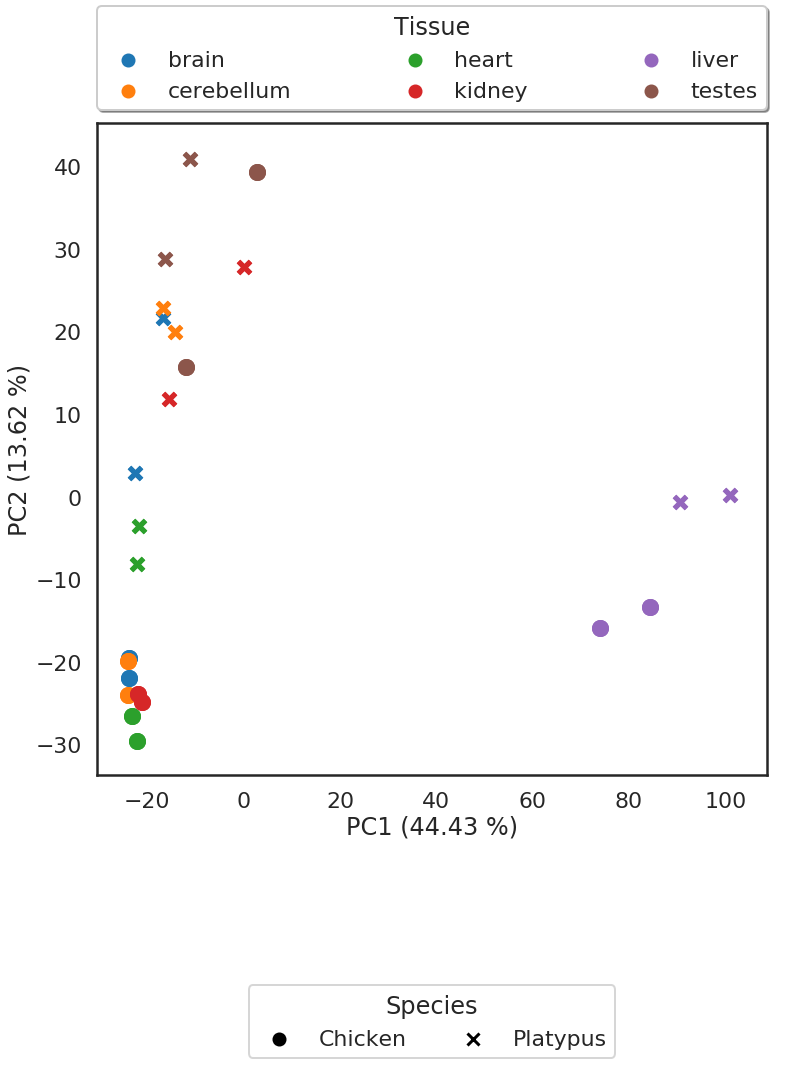

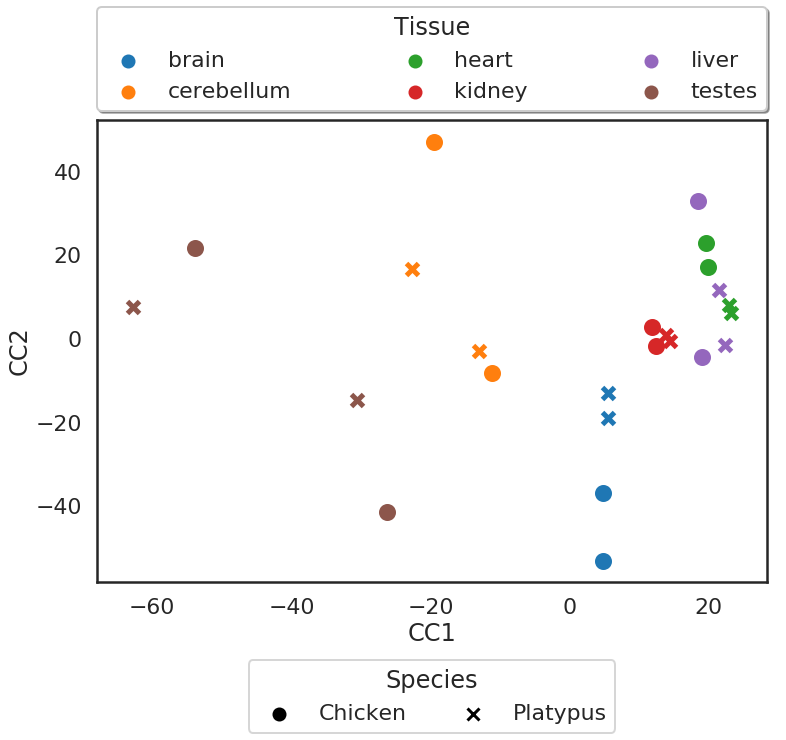

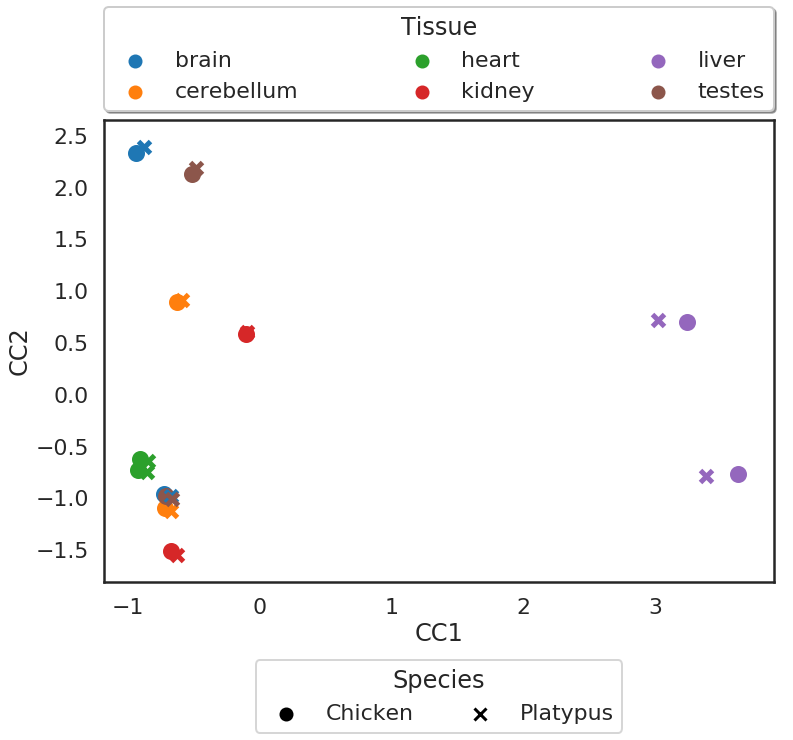

In [140]:
for species_pair, counts in pairwise_kallisto_counts_normalized.items():
    X = counts.values
    target_names = counts.index
    X_r, fig = do_PCA(X, target_names)
    species1, species2 = species_pair.split('_')
    fig.savefig('../{}_plots/pca_normalized_{}_{}.pdf'.format(srp, species, species2), 
                bbox_inches='tight')    
    X = pairwise_kallisto_counts_normalized_individual[species_pair][species1]
    Y = pairwise_kallisto_counts_normalized_individual[species_pair][species2] 
    fig = do_CCA(X, Y, target_names)
    fig.savefig('../{}_plots/cca_normalized_{}_{}.pdf'.format(srp, species, species2),
                bbox_inches='tight')    
    X = X_r[:X.shape[0],]
    Y = X_r[X.shape[0]:,]
    fig = do_CCA(X, Y, target_names)
    fig.savefig('../{}_plots/cca_on_pca_{}_{}.pdf'.format(srp, species, species2),
                bbox_inches='tight')    


## Load All orthologous genes at once

In [141]:
species_wise_tissues = defaultdict(list)

for f in glob.glob('../cross-species-data/SRP007412-*_kallisto_gene_tables.tsv'):
    sample_name = f.split('/')[-1].replace('_kallisto_gene_tables.tsv', '')
    srp, species = sample_name.split('-')
    
    #species = species[0] + species.split('_')[-1]
    df = pd.read_table(f)
    tissues = sorted(set([x.split('_')[1] for x in df.columns]))
    for index, tissue in enumerate(tissues):
        if tissue in TISSUES_SHORT_FORM_MAP.keys():
            tissues[index] = TISSUES_SHORT_FORM_MAP[tissue]
            
    species_wise_tissues[species]+=list(tissues)
srp = 'SRP007412'
ortho_pairwise = {}
all_orthologs = pd.DataFrame()
for f in ['../ortholog_tsv/mmusculus_{}.tsv'.format(x) for x in map(lambda s: species_short(s), species_wise_tissues.keys())]:
    if 'mmusculus_mmusculus' in f:
        continue
    second_species = f.split('/')[-1].replace('.tsv', '').split('_')[-1]
    df = pd.read_table(f)[['ensembl_gene_id', '{}_homolog_ensembl_gene'.format(second_species), '{}_homolog_orthology_type'.format(second_species)]].set_index('ensembl_gene_id')
    df = df[df['{}_homolog_orthology_type'.format(second_species)]=='ortholog_one2one'].drop(columns=['{}_homolog_orthology_type'.format(second_species)])
    all_orthologs = all_orthologs.join(df, how='outer')

In [142]:
SPECIES_FOR_SRP = ['mus_musculus', 'gallus_gallus', 'ornithorhynchus_anatinus', 'macaca_mulatta', 'gorilla_gorilla', 'pan_paniscus', 'pan_troglodytes', 'pongo_abelii', 'homo_sapiens',  'monodelphis_domestica']


In [143]:
all_orthologs_filtered = all_orthologs.copy()
for species in species_wise_tissues.keys():
    species = species_short(species)
    count = kallisto_counts['{}_{}'.format(srp, species)]
    if species == 'mmusculus':
        all_orthologs_filtered = all_orthologs_filtered[all_orthologs_filtered.index.isin(count.index)]
    else:
        all_orthologs_filtered = all_orthologs_filtered[all_orthologs_filtered['{}_homolog_ensembl_gene'.format(species)].isin(count.index)]

        

In [144]:
all_orthologs_filtered.shape

(6054, 9)

In [145]:
all_orthologs_filtered.head()

,ggallus_homolog_ensembl_gene,oanatinus_homolog_ensembl_gene,mmulatta_homolog_ensembl_gene,ggorilla_homolog_ensembl_gene,ppaniscus_homolog_ensembl_gene,ptroglodytes_homolog_ensembl_gene,pabelii_homolog_ensembl_gene,hsapiens_homolog_ensembl_gene,mdomestica_homolog_ensembl_gene
ensembl_gene_id,,,,,,,,,
ENSMUSG00000000001,ENSGALG00000041700,ENSOANG00000002264,ENSMMUG00000005818,ENSGGOG00000000519,ENSPPAG00000038222,ENSPTRG00000001055,ENSPPYG00000001069,ENSG00000065135,ENSMODG00000001975
ENSMUSG00000000028,ENSGALG00000001616,ENSOANG00000028881,ENSMMUG00000021904,ENSGGOG00000004116,ENSPPAG00000028685,ENSPTRG00000014064,ENSPPYG00000011581,ENSG00000093009,ENSMODG00000010162
ENSMUSG00000000037,ENSGALG00000016537,ENSOANG00000022037,ENSMMUG00000005084,ENSGGOG00000015959,ENSPPAG00000039952,ENSPTRG00000021710,ENSPPYG00000020165,ENSG00000102098,ENSMODG00000017144
ENSMUSG00000000078,ENSGALG00000033178,ENSOANG00000006083,ENSMMUG00000010696,ENSGGOG00000002055,ENSPPAG00000040261,ENSPTRG00000048525,ENSPPYG00000002048,ENSG00000067082,ENSMODG00000006714
ENSMUSG00000000085,ENSGALG00000000672,ENSOANG00000002846,ENSMMUG00000017104,ENSGGOG00000017190,ENSPPAG00000042517,ENSPTRG00000000601,ENSPPYG00000001478,ENSG00000010803,ENSMODG00000017337


In [146]:
all_species_combined_counts_df = pd.DataFrame()
specie_wise_counts = []
specie_wise_index_tracker = []
specie_wise_target_names = {}
for index, species in enumerate(SPECIES_FOR_SRP):
    species = species_short(species)
    count = kallisto_counts['{}_{}'.format(srp, species)]
    col_key = '{}_homolog_ensembl_gene'.format(species)
    print(species)
    if index == 0:
        count = count.loc[all_orthologs_filtered.index, ]
        column_order = SRP007412_cols_to_use
        count = count.loc[:, column_order]
        count.columns = ['{}_{}'.format(species, x) for x in count.columns]
        all_species_combined_counts_df = count
        
    else:
        count = count.loc[all_orthologs_filtered[col_key], column_order]
        count.columns = ['{}_{}'.format(species, x) for x in count.columns]
        count.index = all_species_combined_counts_df.index.tolist()
        #assert (count.columns == column_order).all()
        all_species_combined_counts_df = all_species_combined_counts_df.join(count, how='outer')
    
    specie_wise_counts.append(count)
    specie_wise_target_names[species] =     count.columns.tolist()
    specie_wise_index_tracker.append(count.shape[1])

mmusculus
ggallus
oanatinus
mmulatta
ggorilla
ppaniscus
ptroglodytes
pabelii
hsapiens
mdomestica


In [147]:
all_species_combined_counts_df

,mmusculus_kd_F_1,mmusculus_ht_M_1,mmusculus_ht_F_1,mmusculus_cb_F_1,mmusculus_br_M_1,mmusculus_br_F_1,mmusculus_kd_M_1,mmusculus_lv_M_1,ggallus_kd_F_1,ggallus_ht_M_1,...,hsapiens_kd_M_1,hsapiens_lv_M_1,mdomestica_kd_F_1,mdomestica_ht_M_1,mdomestica_ht_F_1,mdomestica_cb_F_1,mdomestica_br_M_1,mdomestica_br_F_1,mdomestica_kd_M_1,mdomestica_lv_M_1
ensembl_gene_id,,,,,,,,,,,,,,,,,,,,,
ENSMUSG00000000001,2863.000000,286.000000,662.000000,820.000000,1470.000000,630.000000,1524.000000,992.000000,1613.707505,984.682400,...,498.715000,842.646000,276.00030,205.99980,115.00000,205.00030,120.99990,293.00020,155.00040,176.00010
ENSMUSG00000000028,59.307130,39.593090,98.130970,94.156600,71.743620,23.943260,28.843430,22.350160,13.000000,1.000000,...,1.000000,21.000000,10.00000,32.00000,29.00000,15.00000,37.00000,74.00000,6.00000,2.00000
ENSMUSG00000000037,10.999998,6.999998,21.999951,16.000001,59.999950,13.000000,4.999999,4.000004,22.000000,10.000000,...,7.056470,10.016400,22.00000,47.00000,19.00000,105.00000,79.00000,321.00000,7.00000,15.00000
ENSMUSG00000000078,1006.995790,681.000300,1591.996400,629.000394,1655.998820,691.000350,460.999520,86.999970,268.000200,317.000100,...,532.000120,447.000499,503.00000,1001.00000,476.00000,80.00000,245.00000,896.00000,242.00000,62.00000
ENSMUSG00000000085,481.560676,667.893397,1303.685490,1067.633200,2321.089641,802.264090,342.433490,130.884585,277.999600,170.999900,...,685.000184,235.999957,223.00000,538.00000,320.00000,456.00000,235.00000,582.00000,143.00000,74.00000
ENSMUSG00000000093,1387.000000,124.000000,335.000000,106.000000,116.000000,45.000000,975.000000,67.000000,927.376000,158.176000,...,2062.001380,166.000100,679.00000,464.00000,318.00000,60.00000,67.00000,118.00000,399.00000,589.00000
ENSMUSG00000000094,5.002850,1.000000,12.018300,25.019200,26.010300,9.001840,2.001100,2.000000,0.000000,3.000000,...,2.083920,2.000220,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000
ENSMUSG00000000120,77.081600,14.345600,27.373300,200.026000,294.821000,81.985800,36.165700,95.713600,19.000000,11.000000,...,291.000000,565.000000,214.99980,450.00000,230.00050,964.00000,117.00000,149.00000,283.00040,1466.99600
ENSMUSG00000000126,44.000000,128.000000,226.000010,34.000000,702.000100,216.999900,30.000000,8.000000,102.000000,10.000001,...,10.008000,7.007080,4.00000,20.00000,14.00000,1.00000,30.00000,96.00000,0.00000,38.00000


In [148]:
specie_wise_index_tracker

[8, 8, 8, 8, 8, 8, 8, 8, 8, 8]

In [149]:
all_species_combined_counts_df_T = all_species_combined_counts_df.T

In [150]:
all_species_combined_counts_df_normalized = normalize_df_rowwise(all_species_combined_counts_df_T)

2018-11-26 00:00:19,707 : gcca.gcca : INFO : data num is 10
2018-11-26 00:00:19,708 : gcca.gcca : INFO : data shape x_0: (6054, 8)
2018-11-26 00:00:19,708 : gcca.gcca : INFO : data shape x_1: (6054, 8)
2018-11-26 00:00:19,708 : gcca.gcca : INFO : data shape x_2: (6054, 8)
2018-11-26 00:00:19,709 : gcca.gcca : INFO : data shape x_3: (6054, 8)
2018-11-26 00:00:19,709 : gcca.gcca : INFO : data shape x_4: (6054, 8)
2018-11-26 00:00:19,709 : gcca.gcca : INFO : data shape x_5: (6054, 8)
2018-11-26 00:00:19,710 : gcca.gcca : INFO : data shape x_6: (6054, 8)
2018-11-26 00:00:19,710 : gcca.gcca : INFO : data shape x_7: (6054, 8)
2018-11-26 00:00:19,710 : gcca.gcca : INFO : data shape x_8: (6054, 8)
2018-11-26 00:00:19,711 : gcca.gcca : INFO : data shape x_9: (6054, 8)
2018-11-26 00:00:19,711 : gcca.gcca : INFO : normalizing
2018-11-26 00:00:19,731 : gcca.gcca : INFO : calc variance & covariance matrix
2018-11-26 00:00:19,747 : gcca.gcca : INFO : adding regularization term
2018-11-26 00:00:19,74

eig_dim: 80


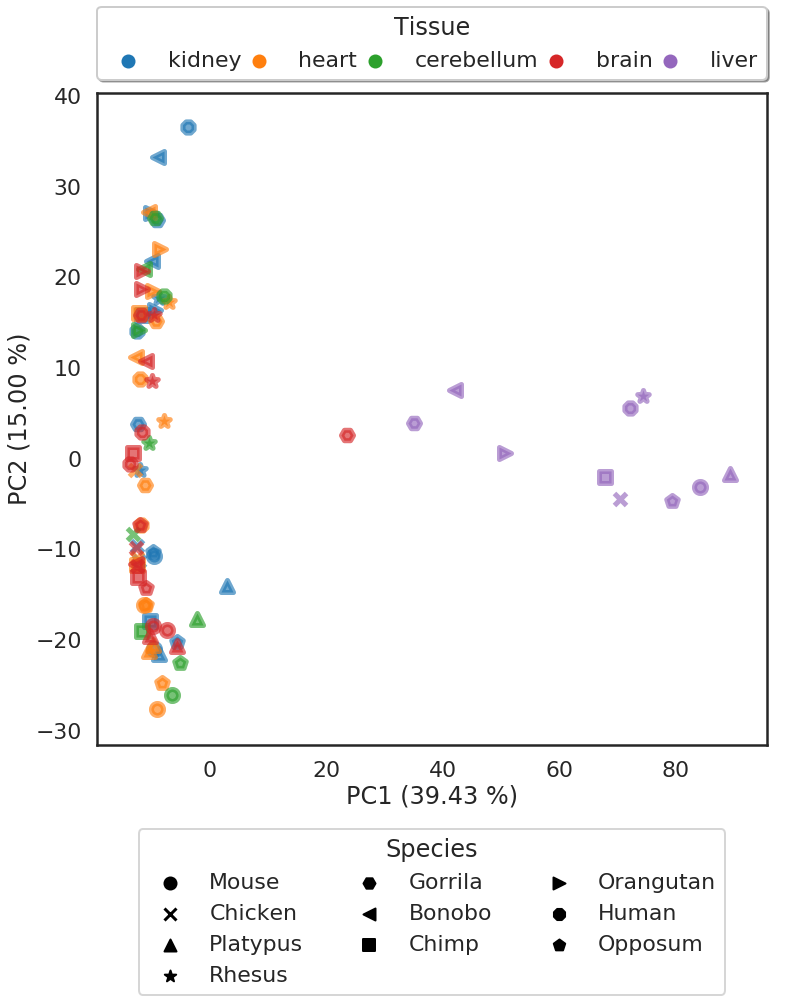

In [180]:
logging.root.setLevel(level=logging.INFO)
gcca = GCCA()

gcca.fit(*specie_wise_counts)





gcca.transform(*specie_wise_counts)

X = all_species_combined_counts_df_normalized.values
target_names = all_species_combined_counts_df_normalized.index
X_r, fig = do_PCA(X, target_names)
#fig.tight_layout()
fig.savefig('../SRP007412_plots/pca_normalized_all.pdf',
            bbox_inches='tight')

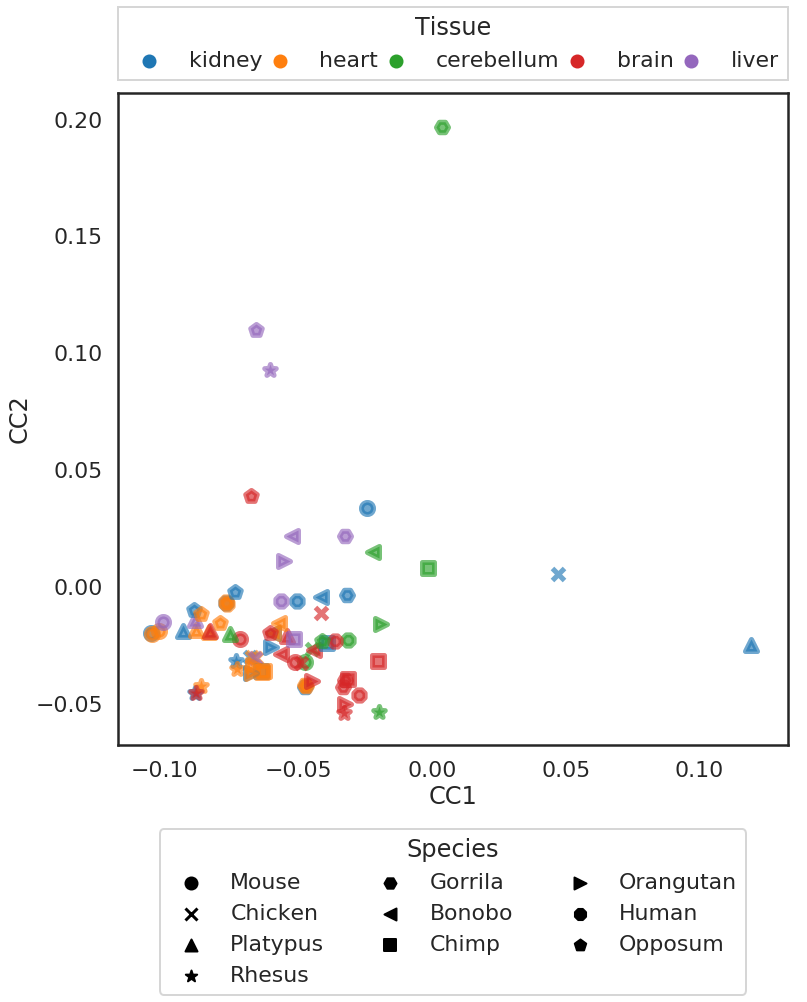

In [171]:
fig , ax  = plt.subplots(figsize=(12, 12))
X_r = gcca.z_list
target_names = all_species_combined_counts_df_normalized.index

indexes, markers_list, colors_list, colors_dict, markers_dict = _get_PCA_colors_markers(target_names)   

        
scatter_points = []
annotations = []
for index, species in enumerate(SPECIES_FOR_SRP):
    target_names = specie_wise_target_names[species_short(species)]
    indexes, _, _, _ , _ = _get_PCA_colors_markers(target_names)
    z_list = X_r[index]
    for tissue, values in indexes.items():
        for value in values:
            ax.scatter(z_list[value, 0], 
                       z_list[value, 1], 
                       alpha=0.4,
                       color=colors_dict[tissue], 
                       marker=markers_dict[species_short(species)],
                       lw=5) 

    
target_names = all_species_combined_counts_df_normalized.index
indexes, markers_list, colors_list, colors_dict, markers_dict = _get_PCA_colors_markers(target_names)   
for tissue, color in colors_dict.items():
    p = ax.scatter([], [], color=color, label=tissue)
    if tissue in TISSUES_SHORT_FORM_MAP.keys():
        tissue = TISSUES_SHORT_FORM_MAP[tissue]
    annotations.append(tissue)
    scatter_points.append(p)


leg = Legend(ax, scatter_points, annotations, title='Tissue',
             bbox_to_anchor=(0., 1.02, 1., .02), loc=0,
             fancybox=False, shadow=False,borderaxespad=0,
             ncol=5, mode="expand")
ax.add_artist(leg)

scatter_points = []
annotations = []
for species, marker in markers_dict.items():
    p = ax.scatter([], [], marker=marker, color='black', label=species)
    annotations.append(SPECIES_COMMON_NAME_MAP_SHORT[species])
    scatter_points.append(p)

#leg = Legend(ax, scatter_points, annotations, title='Species',
#             bbox_to_anchor=(1.04, 0), loc="lower left",)# frameon=False)
#leg = Legend(ax, scatter_points, annotations, title='Species',
#             bbox_to_anchor=(1, 1), loc='upper right',borderaxespad=0,
#             #bbox_to_anchor=(0.5, -0.05), loc=0, ncol=5,
#             )# frameon=False)
leg = Legend(ax, scatter_points, annotations, title='Species', ncol=3, 
             bbox_to_anchor=(0.5, -0.4), loc='lower center',)
ax.add_artist(leg)
ax.set_xlabel('CC1')
ax.set_ylabel('CC2')
#fig.tight_layout()
fig.savefig('../SRP007412_plots/cca_normalized_all.pdf', bbox_inches='tight')
#fig.tight_layout(rect=[0,0,0.8,1])


In [85]:
all_species_combined_counts_df_normalized.T

,mmusculus_kd_F_1,mmusculus_ht_M_1,mmusculus_ht_F_1,mmusculus_cb_F_1,mmusculus_br_M_1,mmusculus_br_F_1,mmusculus_kd_M_1,mmusculus_lv_M_1,ggallus_kd_F_1,ggallus_ht_M_1,...,hsapiens_kd_M_1,hsapiens_lv_M_1,mdomestica_kd_F_1,mdomestica_ht_M_1,mdomestica_ht_F_1,mdomestica_cb_F_1,mdomestica_br_M_1,mdomestica_br_F_1,mdomestica_kd_M_1,mdomestica_lv_M_1
ensembl_gene_id,,,,,,,,,,,,,,,,,,,,,
ENSMUSG00000000001,0.078156,-0.050958,-0.042064,-0.164982,-0.165486,-0.125852,0.079334,0.020532,0.091953,0.005005,...,-0.036321,-0.026502,-0.071058,-0.050801,-0.061021,-0.143632,-0.108045,-0.116756,-0.068120,-0.035848
ENSMUSG00000000028,-0.097270,-0.063956,-0.058266,-0.283332,-0.297267,-0.263618,-0.133442,-0.060327,-0.082526,-0.052678,...,-0.078478,-0.042984,-0.116901,-0.056198,-0.067991,-0.208188,-0.126836,-0.135860,-0.110325,-0.052592
ENSMUSG00000000037,-0.100293,-0.065675,-0.060453,-0.296076,-0.298373,-0.266106,-0.136835,-0.061857,-0.081545,-0.052150,...,-0.077965,-0.043205,-0.114833,-0.055733,-0.068801,-0.177609,-0.117441,-0.114313,-0.110041,-0.051341
ENSMUSG00000000078,-0.037974,-0.030122,-0.015343,-0.196125,-0.147957,-0.111985,-0.071942,-0.054936,-0.054731,-0.034148,...,-0.033502,-0.034439,-0.031936,-0.026144,-0.031766,-0.186103,-0.080306,-0.064155,-0.043478,-0.046818
ENSMUSG00000000085,-0.070850,-0.030813,-0.023627,-0.124605,-0.085275,-0.086693,-0.088815,-0.051276,-0.053641,-0.042709,...,-0.020542,-0.038671,-0.080192,-0.040504,-0.044409,-0.058351,-0.082543,-0.091546,-0.071519,-0.045663
ENSMUSG00000000093,-0.014197,-0.059503,-0.051460,-0.281401,-0.293096,-0.258832,0.001206,-0.056604,0.017142,-0.043461,...,0.096092,-0.040075,-0.001603,-0.042799,-0.044571,-0.192898,-0.120125,-0.132021,0.000992,0.003895
ENSMUSG00000000094,-0.100668,-0.065991,-0.060740,-0.294605,-0.301577,-0.267015,-0.137262,-0.062024,-0.083943,-0.052561,...,-0.078386,-0.043365,-0.118625,-0.057191,-0.070341,-0.213284,-0.135113,-0.142228,-0.112024,-0.052784
ENSMUSG00000000120,-0.096158,-0.065287,-0.060299,-0.266070,-0.276242,-0.250424,-0.132400,-0.054209,-0.081872,-0.052092,...,-0.053915,-0.032071,-0.081571,-0.043233,-0.051702,0.114251,-0.108940,-0.129317,-0.031864,0.088385
ENSMUSG00000000126,-0.098228,-0.059292,-0.054592,-0.293141,-0.237867,-0.219733,-0.133278,-0.061524,-0.072825,-0.052150,...,-0.077715,-0.043265,-0.117935,-0.056570,-0.069206,-0.212945,-0.128402,-0.133941,-0.112024,-0.049127


In [39]:
specie_wise_index_tracker

[8, 8, 8, 8, 8, 8, 8, 8, 8, 8]

2018-11-25 23:27:56,205 : gcca.gcca : INFO : data num is 10
2018-11-25 23:27:56,206 : gcca.gcca : INFO : data shape x_0: (8, 80)
2018-11-25 23:27:56,206 : gcca.gcca : INFO : data shape x_1: (8, 80)
2018-11-25 23:27:56,206 : gcca.gcca : INFO : data shape x_2: (8, 80)
2018-11-25 23:27:56,208 : gcca.gcca : INFO : data shape x_3: (8, 80)
2018-11-25 23:27:56,208 : gcca.gcca : INFO : data shape x_4: (8, 80)
2018-11-25 23:27:56,209 : gcca.gcca : INFO : data shape x_5: (8, 80)
2018-11-25 23:27:56,209 : gcca.gcca : INFO : data shape x_6: (8, 80)
2018-11-25 23:27:56,210 : gcca.gcca : INFO : data shape x_7: (8, 80)
2018-11-25 23:27:56,210 : gcca.gcca : INFO : data shape x_8: (8, 80)
2018-11-25 23:27:56,210 : gcca.gcca : INFO : data shape x_9: (8, 80)
2018-11-25 23:27:56,211 : gcca.gcca : INFO : normalizing
2018-11-25 23:27:56,212 : gcca.gcca : INFO : calc variance & covariance matrix
2018-11-25 23:27:56,215 : gcca.gcca : INFO : adding regularization term
2018-11-25 23:27:56,216 : gcca.gcca : INFO

eig_dim: 70


2018-11-25 23:27:58,733 : gcca.gcca : INFO : sorting eigenvalues & eigenvector
2018-11-25 23:27:58,734 : gcca.gcca : INFO : normalization
2018-11-25 23:27:58,735 : gcca.gcca : INFO : normalization
2018-11-25 23:27:58,736 : gcca.gcca : INFO : normalization
2018-11-25 23:27:58,737 : gcca.gcca : INFO : normalization
2018-11-25 23:27:58,738 : gcca.gcca : INFO : normalization
2018-11-25 23:27:58,738 : gcca.gcca : INFO : normalization
2018-11-25 23:27:58,739 : gcca.gcca : INFO : normalization
2018-11-25 23:27:58,740 : gcca.gcca : INFO : normalization
2018-11-25 23:27:58,740 : gcca.gcca : INFO : normalization
2018-11-25 23:27:58,741 : gcca.gcca : INFO : normalization
2018-11-25 23:27:58,742 : gcca.gcca : INFO : data num is 10
2018-11-25 23:27:58,742 : gcca.gcca : INFO : data shape x_0: (8, 80)
2018-11-25 23:27:58,743 : gcca.gcca : INFO : data shape x_1: (8, 80)
2018-11-25 23:27:58,743 : gcca.gcca : INFO : data shape x_2: (8, 80)
2018-11-25 23:27:58,743 : gcca.gcca : INFO : data shape x_3: (8,

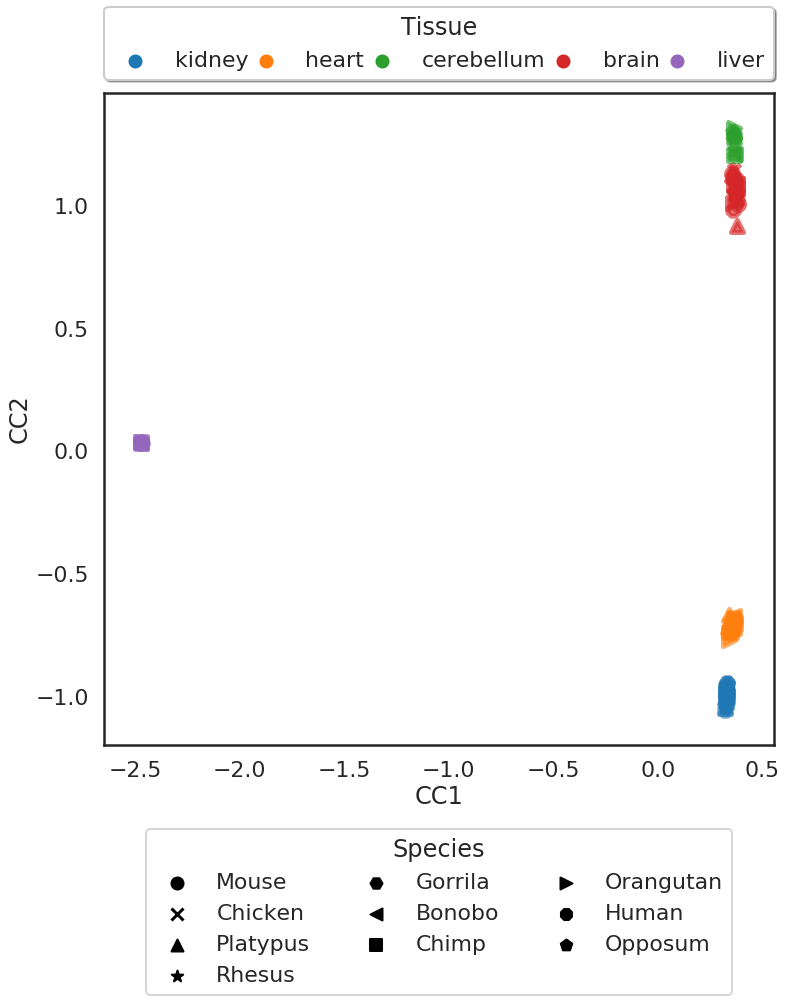

In [172]:
fig , ax  = plt.subplots(figsize=(12, 12))
gcca = GCCA()
PCA_transformed = PCA(n_components=min(all_species_combined_counts_df_normalized.shape)).fit(all_species_combined_counts_df_normalized).transform(all_species_combined_counts_df_normalized)

a = PCA_transformed[:specie_wise_index_tracker[0],:]
b = PCA_transformed[specie_wise_index_tracker[0]:sum(specie_wise_index_tracker[:2]), :]
c = PCA_transformed[sum(specie_wise_index_tracker[:2]):sum(specie_wise_index_tracker[:3]), :]
d = PCA_transformed[sum(specie_wise_index_tracker[:3]):sum(specie_wise_index_tracker[:4]), :]
e = PCA_transformed[sum(specie_wise_index_tracker[:4]):sum(specie_wise_index_tracker[:5]), :]
f = PCA_transformed[sum(specie_wise_index_tracker[:5]):sum(specie_wise_index_tracker[:6]), :]
g = PCA_transformed[sum(specie_wise_index_tracker[:6]):sum(specie_wise_index_tracker[:7]), :]
h = PCA_transformed[sum(specie_wise_index_tracker[:7]):sum(specie_wise_index_tracker[:8]), :]
i = PCA_transformed[sum(specie_wise_index_tracker[:8]):sum(specie_wise_index_tracker[:9]), :]
j = PCA_transformed[sum(specie_wise_index_tracker[:9]):sum(specie_wise_index_tracker[:10]), :]

gcca.fit(a,b,c,d,e,f,g,h,i,j)
gcca.transform(a,b,c,d,e,f,g,h,i,j)
X_r = gcca.z_list
target_names = all_species_combined_counts_df_normalized.index

indexes, markers_list, colors_list, colors_dict, markers_dict = _get_PCA_colors_markers(target_names)   

        
scatter_points = []
annotations = []
for index, species in enumerate(SPECIES_FOR_SRP):
    target_names = specie_wise_target_names[species_short(species)]
    indexes, _, _, _ , _ = _get_PCA_colors_markers(target_names)
    z_list = X_r[index]
    for tissue, values in indexes.items():
        for value in values:
            ax.scatter(z_list[value, 0], 
                       z_list[value, 1], 
                       alpha=0.4,
                       color=colors_dict[tissue], 
                       marker=markers_dict[species_short(species)],
                       lw=5) 

    
target_names = all_species_combined_counts_df_normalized.index
indexes, markers_list, colors_list, colors_dict, markers_dict = _get_PCA_colors_markers(target_names)   
for tissue, color in colors_dict.items():
    p = ax.scatter([], [], color=color, label=tissue)
    if tissue in TISSUES_SHORT_FORM_MAP.keys():
        tissue = TISSUES_SHORT_FORM_MAP[tissue]
    annotations.append(tissue)
    scatter_points.append(p)


leg = Legend(ax, scatter_points, annotations, title='Tissue',
             bbox_to_anchor=(0., 1.02, 1., .02), loc=0,
             fancybox=True, shadow=True,borderaxespad=0,
             ncol=5, mode="expand")
ax.add_artist(leg)

scatter_points = []
annotations = []
for species, marker in markers_dict.items():
    p = ax.scatter([], [], marker=marker, color='black', label=species)
    annotations.append(SPECIES_COMMON_NAME_MAP_SHORT[species])
    scatter_points.append(p)

#leg = Legend(ax, scatter_points, annotations, title='Species',
#             bbox_to_anchor=(1.04, 0), loc="lower left",)# frameon=False)
#leg = Legend(ax, scatter_points, annotations, title='Species',
#             bbox_to_anchor=(1, 1), loc='upper right',borderaxespad=0, shadow=False,
             #bbox_to_anchor=(0.5, -0.05), loc=0, ncol=5,
#            )# frameon=False)
leg = Legend(ax, scatter_points, annotations, title='Species', ncol=3, 
             bbox_to_anchor=(0.5, -0.4), loc='lower center',)
ax.add_artist(leg)
ax.set_xlabel('CC1')
ax.set_ylabel('CC2')
fig.savefig('../SRP007412_plots/cca_on_pca_all.pdf',bbox_inches='tight')

# HO-SVD

In [120]:
from collections import OrderedDict
common_tissue_counts = OrderedDict()
common_tissue_counts_normalized = OrderedDict()
for index, species in enumerate(SPECIES_FOR_SRP):
    species = species_short(species)
    count = kallisto_counts['{}_{}'.format(srp, species)]
    col_key = '{}_homolog_ensembl_gene'.format(species)
    print(species)
    column_order = SRP007412_cols_to_use
    if index == 0:
        count = count.loc[:, column_order]
    else:
        count = count.loc[:, column_order]


    count = count.loc[:, column_order]        
    common_tissue_counts[species] = count
    common_tissue_counts_normalized[species] = normalize_df_colwise(count)

mmusculus
ggallus
oanatinus
mmulatta
ggorilla
ppaniscus
ptroglodytes
pabelii
hsapiens
mdomestica


In [121]:
U, sigmas, V, eigen_values = ho_SVD(common_tissue_counts_normalized.values())

In [122]:
eigen_values

array([8.63438963, 4.82225225, 4.06600823, 2.87040901, 2.29039112,
       2.04270536, 1.19779357, 1.11698875])

In [102]:
sigmas[1]

array([  7.75006257,  10.48517087,  17.10910241,  11.309887  ,
        18.17267101,  20.41299117, 164.25439734, 136.85831428])

In [110]:
sigmas[0].shape

(8,)

In [108]:
angles[0].shape

(8,)

In [ ]:
angles

(-0.7853981633974483, 0.7853981633974483)

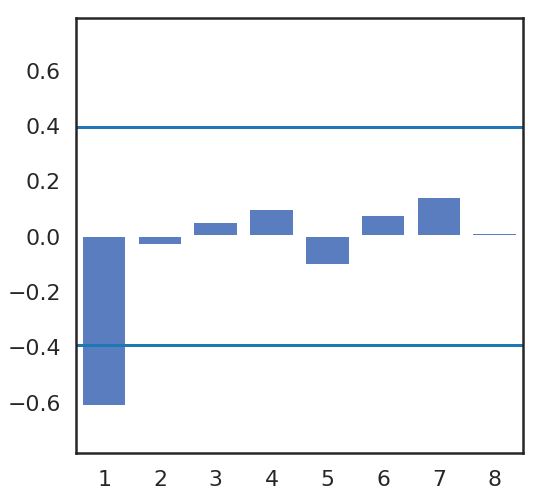

In [123]:
angles = np.arctan2(sigmas[3], sigmas[4]) - np.pi/4
fig, ax = plt.subplots(figsize=(8,8))
sns.set_color_codes("muted")

sns.barplot(x=np.arange(1, len(angles)+1), y=angles, ax=ax, color="b")
ax.axhline(y=np.pi/8)
ax.axhline(y=-np.pi/8)
ax.set_ylim(-np.pi/4, np.pi/4)


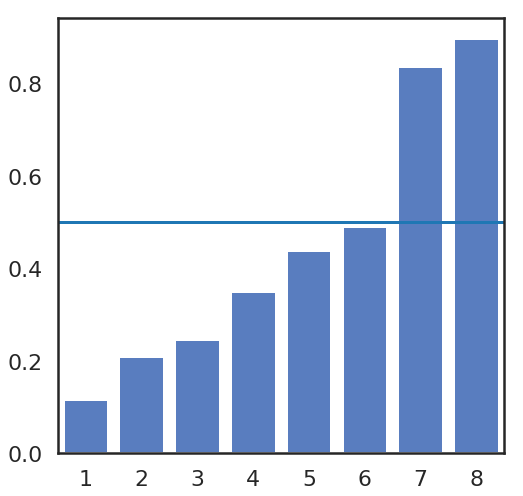

In [124]:
fig, ax = plt.subplots(figsize=(8,8))
sns.set_color_codes("muted")
sns.barplot(x=np.arange(1, len(eigen_values)+1), y=1/eigen_values, ax=ax, color="b")
ax.axhline(y=0.5)


In [215]:
eigen_indexes = np.where(1/eigen_values >= 0.5)
eigen_indexes = eigen_indexes[0]
eigen_indexes =[5,6,7]

In [216]:
common_tissue_counts_normalized.keys()

odict_keys(['mmusculus', 'ggallus', 'oanatinus', 'mmulatta', 'ggorilla', 'ppaniscus', 'ptroglodytes', 'pabelii', 'hsapiens', 'mdomestica'])

In [217]:
# For these inidexes find the top 10% 
# and bottom 10% genes in the projection
species_wise_genes = defaultdict(list)#OrderedDict()
for species_index, species in enumerate(common_tissue_counts_normalized.keys()):
    for eigen_index in eigen_indexes:
        projection = np.dot(U[species_index], V)[:, eigen_index]
        total_genes = len(projection)
        n_genes_to_select = int(0.1 * total_genes)
        bottom10_genes = np.argsort(projection)[:n_genes_to_select]
        top10_genes = np.argsort(projection)[::-1][:n_genes_to_select]
        counts =  kallisto_counts['{}_{}'.format(srp, species)]
        bottom10_genes = counts.iloc[bottom10_genes,:].index.tolist()
        top10_genes = counts.iloc[top10_genes,:].index.tolist()
        species_wise_genes[species] += bottom10_genes + top10_genes

In [218]:

for species, genelist in species_wise_genes.items():
    if species == 'mmusculus':
        genelist2 = all_orthologs_filtered.index.dropna().tolist()
        intersection = len(set(genelist).intersection(genelist2))
    else:
        genelist2 = all_orthologs_filtered['{}_homolog_ensembl_gene'.format(species)].dropna().tolist()
        intersection = len(set(genelist).intersection(genelist2))
    print(species, len(genelist), len(genelist2), intersection/len(all_orthologs_filtered.index))

mmusculus 21342 6054 0.5972910472414932
ggallus 11028 6054 0.3657086223984143
oanatinus 13344 6054 0.42814667988107036
mmulatta 12828 6054 0.4098116947472745
ggorilla 13386 6054 0.38288734720845724
ppaniscus 13050 6054 0.35513709943838784
ptroglodytes 14406 6054 0.4519326065411298
pabelii 12864 6054 0.4002312520647506
hsapiens 21348 6054 0.5470763131813677
mdomestica 13224 6054 0.4283118599273208


In [126]:
# Hypergeometric test

(18389, 8)

In [127]:
U[1][:, 7]

array([0.00052742, 0.00048399, 0.0005293 , ..., 0.00059747, 0.00057996,
       0.00059747])